In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import datetime
import csv
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def read_csv(file_path):
    data = list()
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for raw in reader:
            data.append([float(i) for i in raw])
    return data

def prepare_data(duration):
    input_data = list()
    output_data = list()
    for i in range(29):
        file_path = f"/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/Data/filtered/filtered_{i+1}.csv"
        data = read_csv(file_path)
        num = len (data) - duration - 3
        for j in range(num):
            input_data.append([row for row in data[j:j+duration]])
            output_data.append(data[j+duration+2])
    return np.array(input_data), np.array(output_data)

def split_dataset(data, per):
    total_num = len(data)
    test_num = total_num * per // 100
    train_data = data[0:(total_num - test_num)]
    test_data = data[(total_num - test_num):]
    return train_data, test_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
input_data, output_data = prepare_data(200//4)
input_data = np.squeeze(input_data)
train_data, test_data = split_dataset(input_data, 15)
train_label, test_label = split_dataset(output_data, 15)

Mounted at /content/drive


In [ ]:
def lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(200//4, 9)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model

def gru_model():
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(200//4, 9)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model

def rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(200//4, 9)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(9))
    model.compile(loss='mse', optimizer='adam')
    return model


In [ ]:
n_timesteps = train_data.shape[1]
n_features = train_data.shape[2]
train_data = train_data.reshape(train_data.shape[0], n_timesteps * n_features)
test_data = test_data.reshape(test_data.shape[0], n_timesteps * n_features)
NewScale = MinMaxScaler(feature_range=(0,1), copy=True)
train_data = NewScale.fit_transform(train_data)
test_data = NewScale.fit_transform(test_data)
train_label = NewScale.fit_transform(train_label)
test_label = NewScale.fit_transform(test_label)
train_data = train_data.reshape(train_data.shape[0], n_timesteps, n_features)
test_data = test_data.reshape(test_data.shape[0], n_timesteps, n_features)
train_data, train_label = shuffle(train_data, train_label, random_state=1)
#test_data, test_label = shuffle(test_data, test_label, random_state=1)

In [ ]:
#GRU Network
model_2 = gru_model()
model_2.summary()
start = datetime.datetime.now()
trained_model_2 = model_2.fit(train_data, train_label, batch_size = 32, epochs = 60, verbose=2, validation_split = 0.15)
end = datetime.datetime.now()
train_time = end - start
print("train time for gru is : ",train_time)
model_2.save("/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/gru_model.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                9150      
_________________________________________________________________
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 15,159
Trainable params: 15,159
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
7916/7916 - 168s - loss: 8.1545e-04 - val_loss: 4.0971e-04
Epoch 2/60
7916/7916 - 166s - loss: 2.7306e-04 - val_loss: 1.7937e-04
Epoch 3/60
7916/7916 - 173s - loss: 1.5217e-04 - val_loss: 1.1812e-04
Epoch 4/60
7916/7916 - 169s - loss: 1.0158e-04 - val_loss: 1.0117e-04
Epoch 5/60
7916/7916 - 170s - loss: 8.1821e-05 - val_loss: 8.9362e-05
Epoch 6/60
7916/7916 - 167s - lo

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from keras.models import load_model

#model_2 = load_model('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/gru_model.h5')
#test_data, test_label = shuffle(test_data, test_label, random_state=1)
prediction_2 = model_2.predict(test_data)

start = datetime.datetime.now()
test_loss = model_2.evaluate(test_data, test_label)
mse = mean_squared_error(test_label[:, 8], prediction_2[:, 8])
r2 = r2_score(test_label[:, 8], prediction_2[:, 8])
end = datetime.datetime.now()
test_time = end - start
print("test time for gru is : ",test_time)
print('Test - Loss for gru :', test_loss)
print('Test - MSE for gru :', mse)
print('Test - R2 Score for gru :', r2)

1644/1644 [==============================] - 20s 12ms/step - loss: 4.5278e-04
test time for gru is :  0:00:20.078873
Test - Loss for gru : 0.0004527815035544336
Test - MSE for gru : 0.0004761628229975248
Test - R2 Score for gru : 0.9940306551599623


(52585, 9)


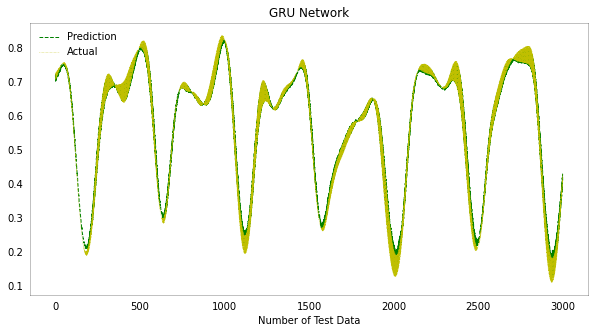

In [ ]:
plt.figure(figsize = [10,5])
print(prediction_2.shape)
plt.plot(prediction_2[10000:13000, 8], label='Prediction', linewidth=1, c='g', linestyle='--')
plt.plot(test_label[10000:13000, 8], label='Actual', linewidth=0.5, c='y', linestyle=':')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.title("GRU Network")
plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                labelbottom=True, left=False, right=False, labelleft=True)   
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
plt.savefig('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/gru_prediction.png', dpi = 600)

Text(0.5, 1.0, 'GRU Network')

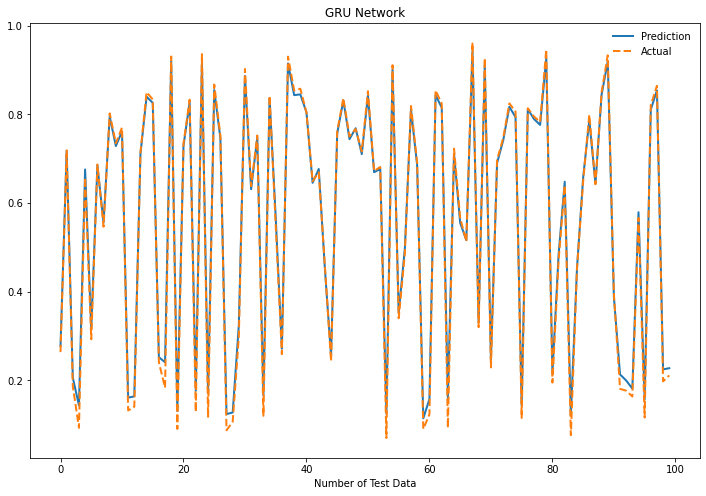

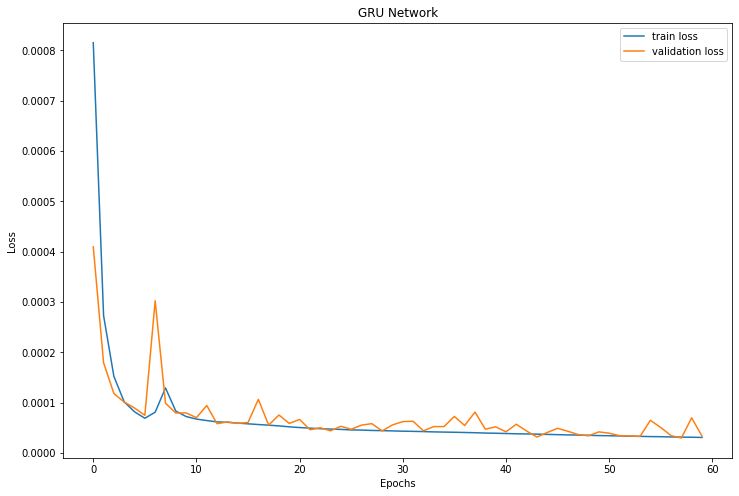

In [ ]:
plt.figure(figsize = [12,8])
plt.plot(prediction_2[0:100, 8], label='Prediction', linewidth=2)
plt.plot(test_label[0:100, 8], label='Actual', linewidth=2, linestyle='--')
plt.legend(frameon=False)
plt.xlabel('Number of Test Data')
plt.title("GRU Network")

history_2 = trained_model_2.history
losses_2 = history_2['loss']
val_losses_2 = history_2['val_loss']

plt.figure(figsize = [12,8])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses_2)
plt.plot(val_losses_2)
plt.legend(['train loss','validation loss'])
plt.title("GRU Network")

In [ ]:
# for load a model use this:
#from keras.models import load_model
#model = load_model('/content/drive/My Drive/Colab Notebooks/HandProsthesisProject/Paper/gru_model.h5')
#more information:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/